# Developing a Predictive Machine Learning Pipeline for London's Climate

As climate change continues to affect global weather patterns, accurate weather prediction has become increasingly vital for businesses. This project focuses on supporting the development of a machine learning pipeline to forecast the climate in London, England, with a specific emphasis on predicting the mean temperature in degrees Celsius (°C).

Given the complex nature of weather prediction, numerous experiments must be conducted to identify the most effective approach. The project entails experimenting with various regression models to predict mean temperature, leveraging a combination of sklearn and mlflow.

The dataset for this project, stored in "london_weather.csv," includes the following columns:
- **date** - the recorded date of measurement (**int**)
- **cloud_cover** - cloud cover in oktas (**float**)
- **sunshine** - sunshine duration in hours (hrs) (**float**)
- **global_radiation** - irradiance in Watts per square meter (W/m²) (**float**)
- **max_temp** - maximum temperature in degrees Celsius (°C) (**float**)
- **mean_temp** - **target** variable, mean temperature in degrees Celsius (°C) (**float**)
- **min_temp** - minimum temperature in degrees Celsius (°C) (**float**)
- **precipitation** - precipitation in millimeters (mm) (**float**)
- **pressure** - atmospheric pressure in Pascals (Pa) (**float**)
- **snow_depth** - snow depth in centimeters (cm) (**float**)

In [119]:
# Run this cell to install mlflow
!pip install mlflow

Defaulting to user installation because normal site-packages is not writeable


In [120]:
# Run this cell to import the modules you require
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

### 1. Loading the data
# Read in the data
weather = pd.read_csv("london_weather.csv")

In [121]:
# Determine the column names, data types, number of non-null values
print(weather.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15341 entries, 0 to 15340
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              15341 non-null  int64  
 1   cloud_cover       15322 non-null  float64
 2   sunshine          15341 non-null  float64
 3   global_radiation  15322 non-null  float64
 4   max_temp          15335 non-null  float64
 5   mean_temp         15305 non-null  float64
 6   min_temp          15339 non-null  float64
 7   precipitation     15335 non-null  float64
 8   pressure          15337 non-null  float64
 9   snow_depth        13900 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 1.2 MB
None


The dataset contains 15,341 entries spread across 10 columns, with 9 columns being of type `float64` and 1 column of type `int64`. Most columns have nearly complete data, but some have missing values. To determine the number of missing values, I compared the total entry count (15,341) with the non-null counts for each column.

Here's the breakdown:
- **"cloud_cover"** and **"global_radiation"** each have 19 missing values (15,341 total entries - 15,322 non-null).
- **"max_temp"** and **"precipitation"** have 6 missing values each (15,341 total entries - 15,335 non-null).
- **"mean_temp"** is missing 36 values (15,341 total entries - 15,305 non-null).
- **"min_temp"** has 2 missing values (15,341 total entries - 15,339 non-null).
- **"pressure"** is missing 4 values (15,341 total entries - 15,337 non-null).
- **"snow_depth"** has the most missing data, with 1,441 missing values (15,341 total entries - 13,900 non-null).

This detailed comparison reveals the extent of missing data in each column.

In [122]:
### 2. Data cleaning
# Convert columns to the correct data type to enable exploratory data analysis
weather['date'] = pd.to_datetime(weather['date'])

In [123]:
# Working with the date column
# Extracting more date information
weather['year'] = weather['date'].dt.year
weather['month'] = weather['date'].dt.month
weather['day'] = weather['date'].dt.day


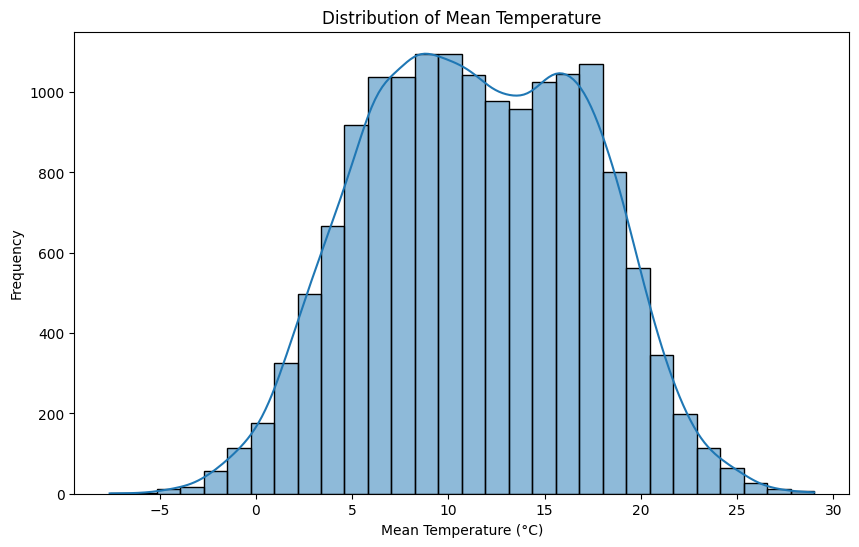

In [124]:
### 3. Exploratory data analysis
# Visualizing temperature
plt.figure(figsize=(10, 6))
sns.histplot(weather['mean_temp'], bins=30, kde=True)
plt.title('Distribution of Mean Temperature')
plt.xlabel('Mean Temperature (°C)')
plt.ylabel('Frequency')
plt.show()


In [125]:
### 4. Feature selection
# Choose appropriate features to predict the mean temperature
# Filter features
selected_features = ['cloud_cover', 'sunshine', 'global_radiation', 'max_temp', 'min_temp', 'precipitation', 'pressure', 'snow_depth']
X = weather[selected_features]
y = weather['mean_temp']

In [126]:
### 5. Preprocess data
# Use an imputer to account for missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Normalize the features using the scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Split the data into train and test samples
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)




In [127]:
### 6. Machine learning training and evaluation
# Initialize MLflow
mlflow.set_tracking_uri('mlruns')
mlflow.sklearn.autolog()


In [128]:
# Regression models to try
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor()
}


In [129]:
# Logging and evaluating
experiment_results = []


In [130]:
# Define a pipeline for preprocessing the target variable
target_imputer = SimpleImputer(strategy='mean')

# Fit the imputer on training data and transform both train and test data
y_train_imputed = target_imputer.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_imputed = target_imputer.transform(y_test.values.reshape(-1, 1)).flatten()

In [131]:
for model_name, model in models.items():
    with mlflow.start_run(run_name=model_name):
        # Train the model
        model.fit(X_train, y_train_imputed)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(y_test_imputed, y_pred))
        
        # Log metrics
        mlflow.log_metric("rmse", rmse)
        
        # Log model
        mlflow.sklearn.log_model(model, model_name)
        
        # Append results
        experiment_results.append({"model": model_name, "rmse": rmse})

In [132]:
# Fetch all logged data relating to MLflow runs
experiment_results = pd.DataFrame(experiment_results)
print(experiment_results)


                     model      rmse
0        Linear Regression  0.916556
1  Decision Tree Regressor  1.266199
2  Random Forest Regressor  0.918886


The experiment results show the performance of three different regression models evaluated using Root Mean Squared Error (RMSE). The **Linear Regression** model has the lowest RMSE of **0.9166**, indicating the best predictive accuracy among the models tested. The **Random Forest Regressor** follows closely with an RMSE of **0.9189**. In contrast, the **Decision Tree Regressor** has the highest RMSE at **1.2662**, suggesting it is the least accurate model of the three.